In [ ]:
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


In [ ]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split

column_names = ['user_id', 'item_id', 'rating', 'timestamp']
train = pd.read_csv('ml-100k/u.data', sep='\t', names = column_names)
train.drop('timestamp', axis =1, inplace = True)

n_users = train.user_id.nunique()
n_movies = train.item_id.nunique()

train_data, test_data = train_test_split(train, test_size=0.25)
train_matrix = np.zeros((n_users, n_movies))
for line in train_data.itertuples():
  train_matrix[line[1]-1, line[2]-1] = line[3]  

test_matrix = np.zeros((n_users, n_movies))
for line in test_data.itertuples():
  test_matrix[line[1]-1, line[2]-1] = line[3]

errs = []
for i in range(1,100):
  U, S, V = svds(train_matrix, i)
  k_rank = U @ np.diag(S) @ V
  err = 0
  for line in test_data.itertuples():
    err += (test_matrix[line[1]-1][line[2]-1]-k_rank[line[1]-1][line[2]-1])**2
  errs.append(err)

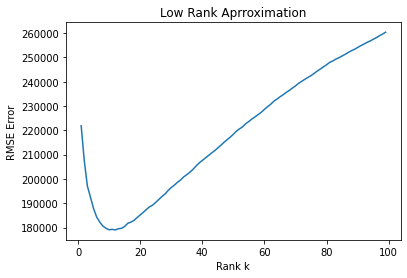

In [ ]:
import matplotlib.pyplot as plt
k = [j for j in range(1,100)]
plt.plot(k, errs)
  
plt.xlabel('Rank k')
plt.ylabel('RMSE Error')
plt.title('Low Rank Aproximation')
plt.show()

In [ ]:
train_X = train_data[['user_id', 'item_id']]
train_y = train_data[['rating']]
train_X = np.array(train_X, dtype = "float")
train_y = np.array(train_y, dtype = "float")
test_X = test_data[['user_id', 'item_id']]
test_y = test_data[['rating']]
test_X = np.array(test_X, dtype = "float")
test_y = np.array(test_y, dtype = "float")

mui = np.zeros(n_users)
etaj = np.zeros(n_movies)

for i in range(n_users):
  avg_r = 0 
  count = 0
  for j in range(n_movies):
    if(train_matrix[i,j]!=0):
      avg_r += train_matrix[i,j]
      count+=1
  if(count!=0):
    mui[i-1] = avg_r/count

for i in range(n_movies):
  avg_r = 0 
  count = 0
  for j in range(n_users):
    if(train_matrix[j,i]!=0):
      avg_r += train_matrix[j,i]
      count+=1
  if(count!=0):
    etaj[i-1] = avg_r/count

for i in range(len(train_X)):
  train_X[i][0] = mui[int(train_X[i][0])-1]
  train_X[i][1] = etaj[int(train_X[i][1])-1]

for i in range(len(test_X)):
  test_X[i][0] = mui[int(test_X[i][0])-1]
  test_X[i][1] = etaj[int(test_X[i][1])-1]

In [ ]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression().fit(train_X, train_y)
print(LR.coef_) # a and b

y_hat = LR.predict(test_X)

err = 0
for i in range(len(test_y)):
  err += (test_y[i]-y_hat[i])**2

print(err)


[[0.0057033  0.29120186]]
[30724.3079183]
